## Sélection et validation des modèles et des hyperparamètres

#### L'objectif est de comprendre : 
- ce qu’est le sur-apprentissage (overfitting), et le sous-apprentissage (underfitting) : biais versus variance 
- comment évaluer correctement un modèle,
- comment sélectionner un modèle ou ses hyperparamètres,
- pourquoi on utilise la cross-validation

### Sur-apprentissage (*overfitting*) et sous-apprentissage (*under-fitting*)

Lorsqu’on entraîne un modèle, son comportement est gouverné par deux aspects fondamentaux (dilemme biais-variance):

- **Le biais :** c’est l’erreur liée au fait que le modèle est trop simple pour bien représenter la relation entre les variables.

  - kNN avec un k très grand
  - arbre de décision peu profond (max_depth très petit)

→ Le modèle lisse trop, il néglige de l’information → il sous-apprend → on parle d’underfitting

- **La variance :** c’est l’erreur liée à la sensibilité aux petites fluctuations des données d'entraînement

  - kNN avec k très petit (k=1)
  - arbre de décision très profond

→ Le modèle suit le bruit et les détails inutiles → il sur-apprend → on parle d’overfitting

Un modèle doit trouver un équilibre biais-variance :
- trop simple → biais élevé, variance faible → mauvaise performance
- trop complexe → variance élevée, biais faible → mauvaise performance
- entre les deux → meilleure généralisation

<table>
  <tr>
    <td><img src="./sous_ajustement.png" width="250"></td>
    <td><img src="./bon_ajustement.png" width="250"></td>
    <td><img src="./sur_ajustement.png" width="250"></td>
  </tr>
</table>


### Evaluation des modèles

Jusqu'ici, on faisait :
- un split train/test unique
- un calcul de la performance sur le test

Mais :
- le split aléatoire influence le résultat
- si on répète plusieurs fois → on obtient des performances différentes

Pour obtenir une estimation fiable de la performance attendue du modèle, on répète :

- split train/test
- entraînement du modèle
- évaluation sur le test
  
→ On obtient une distribution de scores test :
- La moyenne = estimation du score attendu
- L'écart-type = stabilité du modèle

### Sélection des modèles

L’objectif de la séléction du modèle est de :

- choisir l’hyperparamètre optimal (ex : k optimal pour KNN, profondeur pour un arbre, nombre d’arbres pour RF),
- ou choisir entre plusieurs modèles (KNN vs SVM vs RF…),
- en utilisant **uniquement** le train

Pourquoi ne pas utiliser le score train ?

→ Car un modèle peut être excellent sur train et mauvais sur test (overfitting).

Pourquoi ne pas utiliser le test ?

→ Car le test doit rester indépendant et réservé à l’évaluation finale.

Donc on a besoin d’un outil qui est la valiadation croisée *cross-validation*

#### k-fold cross-validation

La *K-fold Cross-Validation* consiste à :

1. **Diviser le jeu d'entraînement en K sous-ensembles disjoints** (appelés *folds*).  
2. **Répéter K fois** :
   - sélectionner **1 fold comme validation**,  
   - entraîner le modèle sur les **K−1 folds restants**,  
   - évaluer le modèle sur le fold laissé de côté (validation).  
3. **Calculer la performance finale** comme la moyenne des K scores obtenus.

L’estimateur de l’erreur attendue est alors :

$$
\text{CV}(\hat{f}, \theta)
=
\frac{1}{K}
\sum_{k=1}^{K}
\text{Err}_k(\hat{f}, \theta)
$$

On obtient ainsi :

- une estimation fiable de la performance attendue,  
- sans toucher au test final,  
- une méthode adaptée à la sélection d’hyperparamètres


### Cross-validation à 5 folds : 

| Modèle | Fold 1 | Fold 2 | Fold 3 | Fold 4 | Fold 5 |
|-----------|--------|--------|--------|--------|--------|
| **1** | **validation** | train | train | train | train |
| **2** | train | **validation** | train | train | train |
| **3** | train | train | **validation** | train | train |
| **4** | train | train | train | **validation** | train |
| **5** | train | train | train | train | **validation** |


#### Paramètres *versus* Hyperparamètres ? 

- Paramètres : valeurs apprises par l’algorithme pendant l’entraînement (exp coefficients et intercept d’une régression linéaire, les indices de variables utilisées pour chaque split et les seuils de split dans Random Forest)

- Hyperparamètres : réglages définis avant l’entraînement qui contrôlent le modèle et l’optimisation (exp force de régularisation λ pour Ridge/Lasso, degré du polynôme, n_estimators et max_features pour RandomForest).

- Différence clé : paramètres = appris ; hyperparamètres = choisis par l’utilisateur (via une recherche).

- Workflow minimal : séparer train/validation/test (ou CV) → pour chaque combinaison d’hyperparamètres entraîner sur train → évaluer sur validation → choisir les meilleurs → tester une seule fois sur test final.


#### Variantes de la cross-Validation dans scikit-learn

Scikit-learn propose plusieurs versions de la cross-validation, chacune adaptée à un type de données ou de contrainte différente :

- **KFold**  
  Division simple en K folds. Les données sont découpées séquentiellement ou mélangées (option `shuffle=True`).  
  ➜ Version standard pour jeux de données équilibrés.

- **StratifiedKFold**  
  Comme KFold, mais en conservant **la proportion des classes** dans chaque fold.  
  ➜ Indispensable pour la **classification** lorsque les classes sont déséquilibrées.

- **GroupKFold**  
  Garantit que tous les échantillons appartenant au **même groupe** (exp même parcelle) sont placés dans le *même* fold.  
  ➜ Utile lorsqu’il ne faut jamais mélanger des données corrélées.

- **StratifiedGroupKFold**  
  Combine les deux : respecte à la fois les **groupes** et la **stratification** des classes.  
  ➜ Utilisé dans des cas complexes (exp plusieurs observations par parcelle + classes déséquilibrées).

- **ShuffleSplit / StratifiedShuffleSplit**  
  Effectue plusieurs tirages aléatoires train/test sans structure en K folds.  
  ➜ Plus flexible, c’est une forme de *random permutation cross-validation*, utile pour produire plusieurs estimations indépendantes lorsque la structure en folds n’est pas importante

- **Leave-One-Out (LOO)**  
  Chaque échantillon est utilisé une fois comme validation.  
  ➜ Très coûteux, mais informatif pour petits datasets.

### Exemple pratique : Cross-validation + GridSearch

In [1]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier as RF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Charger un dataset depuis un CSV
# df = pd.read_csv("/home/yhamrouni/Documents/1_enseignement/2025_2026/data_mining/4_classification_prof/")
df = pd.read_csv("./landcover_synthetic.csv")

# Encodage numérique des classes (softmax exige des entiers)
# Transforme la colonne 'label' en catégories et 
# attribue un numéro par classe (0, 1, 2...)
df["label_code"] = df["label"].astype("category").cat.codes

# On récupère la liste des noms de classes dans l'ordre des codes
class_names = df["label"].astype("category").cat.categories

# Extraction des variables explicatives (X) comme un tableau NumPy 2D
X = df[["NDVI", "Texture"]].values

# Extraction de la variable cible (y) comme un tableau NumPy 1D
y = df["label_code"].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=0)


In [3]:
# Définition du modèle et de la grille d'hyperparamètres

rf = RF(random_state=0)

param_grid = {
    "n_estimators": [1, 10, 50, 100, 200, 500],    # nombre d'arbres
    "max_depth": [None, 5, 10, 15],        # profondeur maximale des arbres (None = arbre entièrement développé)
    # "max_features": ["sqrt", "log2"],  # nombre de variables testées à chaque split (valeurs plus faibles → plus les arbres sont différents → meilleure diversité)
    # "min_samples_leaf": [1, 2, 4],     # nombre minimal d’échantillons dans une feuille (valeurs plus grandes → arbres plus simples → moins d’overfitting)
    }

# Cross-validation stratifiée (conserve proportion des classes)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Grille de recherche
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1  # utilise tous les CPU pour aller plus vite
)

# Entraînement avec recherche des meilleurs hyperparamètres 
grid.fit(X_train, y_train)

print("Meilleurs hyperparamètres trouvés :")
print(grid.best_params_)

# Score moyen CV
print(f"Score CV moyen : {grid.best_score_:.2f}")

# Modèle final (entraîné sur tout le train) 
best_model = grid.best_estimator_

# Evaluation sur le test
y_pred = best_model.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)

print(f"Accuracy test : {acc_test:.2f}")


Meilleurs hyperparamètres trouvés :
{'max_depth': 5, 'n_estimators': 100}
Score CV moyen : 0.93
Accuracy test : 0.96


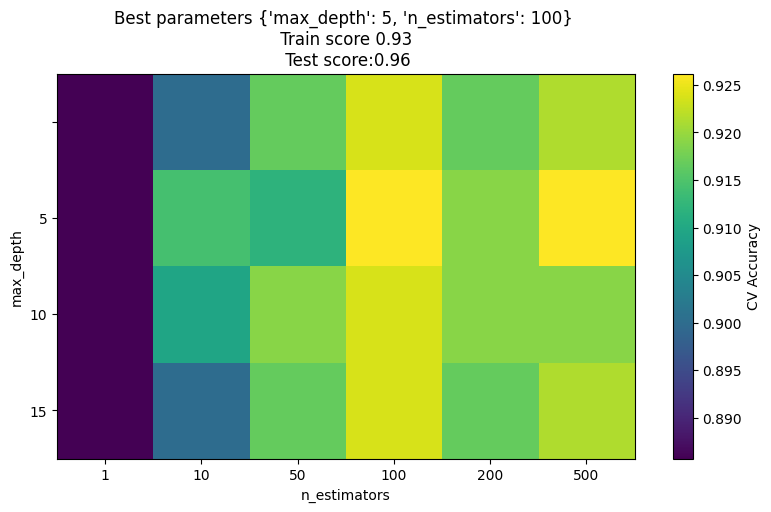

In [4]:
# On récupère les résultats sous forme de tableau
mean_scores = grid.cv_results_["mean_test_score"]

# Nombre de valeurs par hyperparamètre
M = len(param_grid["max_depth"])
N = len(param_grid["n_estimators"])

# On reshape (attention à l'ordre !)
heatmap_values = mean_scores.reshape(M, N)

fig, ax = plt.subplots(figsize=(10, 5))

im = ax.imshow(heatmap_values, cmap="viridis")

# Axe X = n_estimators
ax.set_xticks(range(N))
ax.set_xticklabels(param_grid["n_estimators"])

# Axe Y = max_features
ax.set_yticks(range(M))
ax.set_yticklabels(param_grid["max_depth"])

plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.title("GridSearchCV — Mean CV Accuracy")

cb = fig.colorbar(im, ax=ax)
cb.set_label("CV Accuracy")
ax.set_title(f"Best parameters {grid.best_params_} \n Train score {grid.best_score_:.2f} \n Test score:{acc_test:.2f}")
plt.show()
